1900-01-01 10:32:58


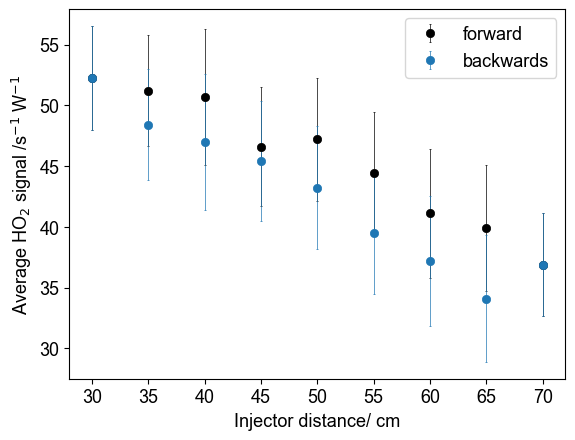

In [65]:

#Author: [Abigail McConnell]
#Date Created: 2023-02-25
#Last Modified: 2025-05-26
#Script Name: HO2_uptake_workup_automated_timings.py
#Description:
#    This script processes and analyses data from measuring HO2 uptake, using the automated timings injector (30 sm - 70 cm). 
#    After importing the data it averages the normalised HO2 signal plotting it against injector distance for both the forward 
#    and backward direction. The second box plots the ln(HO2) vs residence time inside the flowtube, fitting a linear regression 
#    and outputting the associated error. This is your pseudo first order rate for HO2 loss onto aerosols or the walls. 

#Requirements:
#    - pandas
#    - numpy
#    - matplotlib


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Set up initial parameters (time, time correction, laser power constants)--- #

# Define start time (taken from the actual time) and define the time correction (difference from the actual time to the computer logging the signal)
start_time = pd.to_datetime('1900-01-01 10:38:11') - pd.Timedelta(minutes=5, seconds=13)

# Laser power correction coefficients - these are from the laser power calibration 
LASER_CORRECTION_SLOPE = 0.8456
LASER_CORRECTION_INTERCEPT = 1.1115

# Laser power threshold for filtering
LASER_POWER_THRESHOLD = 1.0


# --- Load and preprocess laser power data --- #


# import laser power file 
dflp = pd.read_csv('20250115_lp1.txt', sep="\t", header=None, skiprows=8, engine='python', encoding='unicode_escape')
dflp.columns = ['sample', 'time1', 'Channel 1', 'Laser power', 'Channel 2', 'Channel 3']

# Convert time and apply time correction (difference from the actual time to the computer logging the laser power)
dflp['time1'] = pd.to_datetime(dflp['time1'], format='%H:%M:%S')
dflp['time'] = dflp['time1'] - pd.Timedelta(minutes=5, seconds=13)

# Avereage the values over 1 second intervals 
dflp = dflp.groupby(pd.Grouper(key='time', freq='1s')).mean()


# --- Load and preprocess signal data --- #

# import signal file 
df1 = pd.read_csv('20250115_signal1.txt', sep="\t", header=None, skiprows=1, engine='python', encoding='unicode_escape')
df1.columns = ['time', 'Signal', 'Channel B', 'Status', 'Aerosol Conc', 'Injector position']
df1['time'] = pd.to_datetime(df1['time'], format='%H:%M:%S')

# Merge with laser power data
df = pd.merge_asof(dflp, df1, on='time')

# Turn logged laser power into corrected laser power 
df['laser power corrected'] = df['Laser power'] * LASER_CORRECTION_SLOPE + LASER_CORRECTION_INTERCEPT

# Normalise signal by corrected laser power
df['normalsed signal'] = df['Signal'] / df['laser power corrected']


# --- Define injection timing windows --- #

# Each window is 20 seconds, with 15 seconds 'waiting time' between each time window 
def make_time_windows(start, interval=15, duration=20, count=9):
    """Generate consecutive time windows from a start time."""
    windows = []
    current = start
    for _ in range(count):
        begin = current + pd.Timedelta(seconds=interval)
        end = begin + pd.Timedelta(seconds=duration)
        windows.append((begin, end))
        current = end
    return windows

# Forward windows - when the injector is moving from 30 cm to 70 cm 
forward_windows = make_time_windows(start_time - pd.Timedelta(seconds=15), interval=15, duration=20)

# Backward windows, with a different first interval- when the injector is moving from 70 cm to 30 cm 
start_time_back = forward_windows[-1][1] + pd.Timedelta(seconds=15)
backward_windows = make_time_windows(start_time_back, interval=15, duration=20)
backward_windows[-1] = (backward_windows[-1][0], start_time + pd.Timedelta(seconds=10))  # Final backwards window ends early


# --- Background filtering --- #

# This is where you can change the background signal labelling- depending on what is used during the experiment
dfbg = df[(df['Status'] == 'Offline') & 
          (df['Aerosol Conc'] == 0.0) & 
          (df["Injector position"] == 25.0) &
          (df['Laser power'] > LASER_POWER_THRESHOLD)]

avbg = dfbg['normalsed signal'].mean()
stdbg = dfbg['normalsed signal'].std()


# --- Helper functions --- #

def process_window(df, time_window):
    """Filter and process data for a time window."""
    window_df = df[(df['time'] >= time_window[0]) & (df['time'] <= time_window[1])]
    filtered_df = window_df[window_df['Laser power'] > LASER_POWER_THRESHOLD]
    avg_signal = filtered_df['normalsed signal'].mean() - avbg
    std_signal = np.sqrt(filtered_df['normalsed signal'].std()**2 + stdbg**2)
    ln_error = (std_signal - stdbg) / avg_signal if avg_signal != 0 else np.nan
    return avg_signal, std_signal, ln_error


# --- Process all forward and backward windows --- #

# averages, errors, ln_errors = from the forward direction of the injector (30 cm to 70 cm)
averages, errors, ln_errors = zip(*[process_window(df, win) for win in forward_windows])

#  averagesb, errorsb, ln_errorsb = from the backward direction of the injector (70 cm to 30 cm)
averagesb, errorsb, ln_errorsb = zip(*[process_window(df, win) for win in backward_windows])

ln_av = np.log(averages)
ln_avb = np.log(averagesb)

# Injector distances in cm and residence times in seconds (work this out in the residence time Excel spreadsheet)

distances = np.array([30, 35, 40, 45, 50, 55, 60, 65, 70])
times = np.array([7.75, 9, 10.2, 11.49, 12.74, 14, 15.2, 16.5, 17.7])


# --- Plotting --- #

plt.figure(figsize=(8, 5))

plt.errorbar(distances, averages, yerr=errors, fmt="o", color='k', capsize=1,
             elinewidth=0.5, markeredgewidth=0.5, label='Forward')
plt.errorbar(distances, averagesb, yerr=errorsb, fmt="o", capsize=1,
             elinewidth=0.5, markeredgewidth=0.5, label='Backward')

# Axis titles 
plt.ylabel('Average HO$_2$ signal /s$^{-1}$ W$^{-1}$')
plt.xlabel('Injector distance / cm')

# Change plot font sizes 
plt.rcParams.update({
    "font.family": "Arial",
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 13,
    'axes.titlesize': 13
})

plt.legend()
# plt.savefig('wall_loss_1.png', dpi=900)
plt.tight_layout()


# Change the name of your file depending on the aerosol concentration or if it was a woll loss experiment  
# plt.savefig('wall_loss_1.png', dpi=900)

In [ ]:
##### FORWARD AND BACKWARDS INJECTOR: ln(HO₂ Signal) vs residence Time #####

# Plot ln(signal) with error bars for both forward and backward measurements
plt.errorbar(time, ln_av, yerr=ln_er, fmt="o", color='k',
             capsize=1, elinewidth=0.5, markeredgewidth=0.5, label='Forward')
plt.errorbar(time, ln_avb, yerr=ln_erb, fmt="o", color='gray',
             capsize=1, elinewidth=0.5, markeredgewidth=0.5, label='Backward')

# Label axes
plt.ylabel('ln(HO$_2$ signal)', fontsize=13)
plt.xlabel('Exposure time / s', fontsize=13)

# Set consistent font and plot appearance
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['axes.titlesize'] = 13

# Combine time and signal data from both directions
x = np.tile(time, 2)
y = np.concatenate((ln_av, ln_avb))
y_err = np.concatenate((ln_er, ln_erb))

# Perform linear regression (1st degree polynomial fit)
slope, intercept = np.polyfit(x, y, 1)
plt.plot(x, slope * x + intercept, color='k', alpha=0.5, lw=0.5, label='Linear Fit')

# Add legend
plt.legend()

# Get covariance matrix to estimate uncertainty of slope
(popt, pcov) = np.polyfit(x, y, 1, cov=True)
slope_err = np.sqrt(pcov[0][0])

# Print slope and its standard deviation (this is the first order rate of loss for HO2 to the aerosols or walls of the flowtube)
print(f"Slope (k): {popt[0]:.4f} ± {slope_err:.4f}")

# Optionally save the figure
# plt.savefig('ln_wall_loss_fit.png', dpi=900)


In [73]:
##### FORWARD AND BACKWARDS COMBINED ##############

# import the necessary python packages
import numpy as np
import matplotlib.pyplot as plt
 
# odr function from scipy package
# is used to perform ODR regression
from scipy import odr 


sy = y_er

def func(p, x):
   m, c = p
   return m*x + c

model = odr.Model(func)

data = odr.RealData(x,y,sy=sy)

# estimate the gradient and intercept as a first guess for the regression 
odr = odr.ODR(data,model,beta0=[-0.001,2])


# outputs your Beta (gradient, y-intercept) and Beta Std Error and Covariance  
output = odr.run()
output.pprint()

Beta: [-0.03767818  4.25588994]
Beta Std Error: [0.00321041 0.03958184]
Beta Covariance: [[ 4.21093226e-05 -5.00509084e-04]
 [-5.00509084e-04  6.40100523e-03]]
Residual Variance: 0.24476185623438
Inverse Condition #: 0.0016310734696052417
Reason(s) for Halting:
  Sum of squares convergence


In [ ]:
##### FORWARD ONLY: ln(HO₂ Signal) vs Exposure Time #####

# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr  # For orthogonal distance regression

# Plot FORWARD ln(HO₂ signal) data with error bars
plt.errorbar(time, ln_av, yerr=ln_er, fmt="o", color='k',
             capsize=1, elinewidth=0.5, markeredgewidth=0.5)

# Axis labels
plt.ylabel('ln(HO$_2$ signal)', fontsize=13)
plt.xlabel('Exposure time / s', fontsize=13)

# Font and plot style settings
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['axes.titlesize'] = 13

# Assign data to x and y variables
x = time
y_f = ln_av

# ---- Ordinary Least Squares Linear Fit ----
slope, intercept = np.polyfit(x, y_f, 1)
plt.plot(x, slope * x + intercept, color='gray', label='OLS fit')

# Estimate uncertainty using covariance matrix
(p, V) = np.polyfit(x, y_f, 1, cov=True)
slope_err = np.sqrt(V[0][0])
print(f"OLS slope (k): {p[0]:.4e} ± {slope_err:.4e} s⁻¹")

# Optional: Annotate plot with rate constant
# plt.text(9, 1, '-k$_{wall}$ = {:.3f} s$^{{-1}}$'.format(slope), size=14)

# ---- Orthogonal Distance Regression (ODR) ----

# Define model function for ODR
def linear_func(p, x):
    m, c = p
    return m * x + c

model = odr.Model(linear_func)

# Convert error array and assign to RealData object
y_err = np.array(ln_er)
data = odr.RealData(x, y_f, sy=y_err)

# Set initial parameter guesses [slope, intercept]
odr_instance = odr.ODR(data, model, beta0=[-0.001, 2])

# Run ODR fitting
output = odr_instance.run()
output.pprint()  # Print detailed fit results

# Optional: Plot title
plt.title('Backward Only')

# Optional: Save figure
# plt.savefig('ln_wall_loss_forward.png', dpi=900)

# Show the final plot
plt.legend()
plt.show()


x_1: -0.04086915087279829 +/- 0.004015844312238946
Beta: [-0.04070045  4.26416985]
Beta Std Error: [0.00364356 0.04476429]
Beta Covariance: [[ 8.35854202e-05 -9.90527775e-04]
 [-9.90527775e-04  1.26166100e-02]]
Residual Variance: 0.15882566594917608
Inverse Condition #: 0.0016139021908721522
Reason(s) for Halting:
  Sum of squares convergence


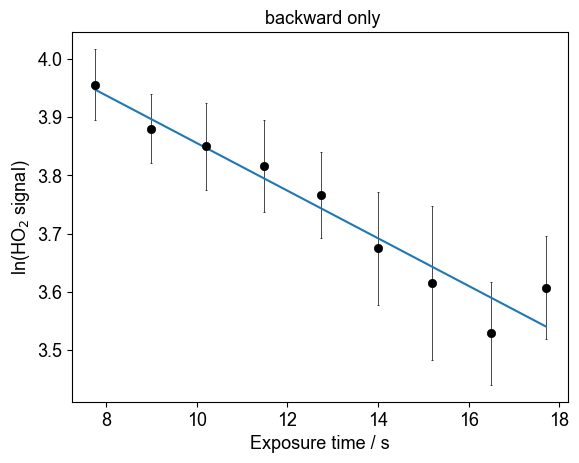

In [77]:
##### BACKWARD ONLY: ln(HO₂ Signal) vs Exposure Time #####

# Import required packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import odr  # For orthogonal distance regression

# Plot BACKWARD ln(HO₂ signal) data with error bars
plt.errorbar(time, ln_avb, yerr=ln_erb, fmt="o", color='k',
             capsize=1, elinewidth=0.5, markeredgewidth=0.5)

# Axis labels
plt.ylabel('ln(HO$_2$ signal)', fontsize=13)
plt.xlabel('Exposure time / s', fontsize=13)

# Font and plot style settings
plt.rcParams["font.family"] = "Arial"
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['xtick.labelsize'] = 13
plt.rcParams['ytick.labelsize'] = 13
plt.rcParams['legend.fontsize'] = 13
plt.rcParams['axes.titlesize'] = 13

# Assign data to x and y variables
x = time
y_b = ln_avb

# ---- Ordinary Least Squares Linear Fit ----
slope, intercept = np.polyfit(x, y_b, 1)
plt.plot(x, slope * x + intercept, color='gray', label='OLS fit')

# Estimate uncertainty using covariance matrix
(p, V) = np.polyfit(x, y_b, 1, cov=True)
slope_err = np.sqrt(V[0][0])
print(f"OLS slope (k): {p[0]:.4e} ± {slope_err:.4e} s⁻¹")

# Optional: Annotate plot with rate constant
# plt.text(9, 1, '-k$_{wall}$ = {:.3f} s$^{{-1}}$'.format(slope), size=14)

# ---- Orthogonal Distance Regression (ODR) ----

# Define model function for ODR
def linear_func(p, x):
    m, c = p
    return m * x + c

model = odr.Model(linear_func)

# Convert error array and assign to RealData object
y_errb = np.array(ln_erb)
data = odr.RealData(x, y_b, sy=y_errb)

# Set initial parameter guesses [slope, intercept]
odr_instance = odr.ODR(data, model, beta0=[-0.001, 2])

# Run ODR fitting
output = odr_instance.run()
output.pprint()  # Print detailed fit results

# Optional: Plot title
plt.title('Backward Only')

# Optional: Save figure
# plt.savefig('ln_wall_loss_backward.png', dpi=900)

# Show the final plot
plt.legend()
plt.show()
